# Phase 1b - Evaluation of 9 Neural Networks (U-Nets)

Code framework from 
https://www.depends-on-the-definition.com/unet-keras-segmenting-images/ re-used and customised for the purposes of this project

In [1]:
import os
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import MRASegmentation as mra
import unets.UNetModels as un
import utils.support as sup

from keras.callbacks import EarlyStopping, ModelCheckpoint 

/Users/rvh/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


No MRA scans are available and nothing can be processed. Set up source data in directory data/source/


We start by creating an instance for the MRA blood vessel segmentation process. Then we read in all the MRA Record ids for the provided cerebral MRA scans. 

In [4]:
app = mra.MRASegmentation()
mra_all = app.get_mra_source_ids()

In the first step we create 9 image projections and corresponding projections of ground truth data for all 10 patient records that have been made available for this project.
IMPORTANT: SET DEBUG=Yes in the ini-file, as data stored in this directory will be used by the training processes of the nine neural networks (UNETS). 1 UNET is trained for each image projection. 

In [5]:
if not app._debug: 
    print ("Set the debug parameter to YES, prior to proceeding with this notebook")
    raise ValueError
else: 
    app.set_up_debug_directories (mra_all)
    for nme in mra_all:  
        app._mra_id = nme
        src = app.get_3d_mra_source(nme) 
        app.get_2d_mra_src_projs(src)
        gt = app.get_3d_mra_gt(nme)
        app.get_2d_mra_gt_projs(gt)
        print('Record '+nme+' processed successfully.') 

Record MNI_0656 processed successfully.
Record MNI_0657 processed successfully.
Record MNI_0592 processed successfully.
Record MNI_0643 processed successfully.
Record MNI_0663 processed successfully.
Record MNI_0664 processed successfully.
Record MNI_0590 processed successfully.
Record MNI_0591 processed successfully.
Record MNI_0640 processed successfully.
Record MNI_0648 processed successfully.


Create instance of 9 UNET models by loading coefficients from model path

In [6]:
print('Model Path: ' + app._model_path)
unets = un.MRA_UNets(app._model_path,
                    app._no_slices,
                    app._img_height,
                    app._img_width,
                    app.NO_PROJECTIONS,
                    app._unet_threshold)


Model Path: data/models-3/


Evaluation of the Results against Performance Metrics (this part is executed against existing UNET models, that had been trained in Jupyter Notebook File '1a - UNet Training.ipynb'

In [7]:
 
# Training data 
dim     = app._img_height+app._img_width+app._no_slices # be generous with the max size of 2D projection images
lngth   = len(mra_all)
gt_trn   = np.zeros((app.NO_PROJECTIONS,lngth, dim, dim), dtype=int) 
pred_trn = np.zeros((app.NO_PROJECTIONS,lngth, dim, dim), dtype=int) 

for i in range(app.NO_PROJECTIONS):  
    projection = str(i+1)
    print('Projection '+projection)
    model = unets.load_model(projection)
    
    # get padded image dimensions that should be used in neural network 
    h, w = unets.get_image_projection_size (projection)

    j=0
    for f in (mra_all): 
        print('... '+f)
        # Load ground truth of image projection 
        img = cv2.imread(app._debug_path + f +'/Step2 2D-GT-Projection-' + projection + '.jpg')
        ho, wo = unets.get_image_size (projection)
        gt_img = sup.convert_image_to_grey(img,ho,wo)
        gt_img = (gt_img > app._gt_pxl_threshold)
        gt_img = gt_img.astype(int)
        gt_trn[i,j,:ho,:wo] = gt_img
        
        # calculate predicted map, based on unet configuration 
        img = cv2.imread(app._debug_path + f +'/Step2 2D-Source-Projection-' + projection + '-CLAHE.jpg')
        ho, wo = unets.get_image_size (projection)
        x_img = sup.convert_image_to_grey(img,ho,wo)
        x_img = x_img / 255.0
        src_nn = np.zeros((1, h, w, 1), dtype=np.float32) 
        src_nn [0,:ho,:wo,0] = x_img
        pred = model.predict(src_nn, verbose=0)
        pred = (pred > app._unet_threshold)
        pred = pred.squeeze()
        pred = pred.astype(int)
        pred_trn[i,j,:ho,:wo] = pred[:ho,:wo]
        j = j+1
        
        

Projection 1
... MNI_0656
... MNI_0657
... MNI_0592
... MNI_0643
... MNI_0663
... MNI_0664
... MNI_0590
... MNI_0591
... MNI_0640
... MNI_0648
Projection 2
... MNI_0656
... MNI_0657
... MNI_0592
... MNI_0643
... MNI_0663
... MNI_0664
... MNI_0590
... MNI_0591
... MNI_0640
... MNI_0648
Projection 3
... MNI_0656
... MNI_0657
... MNI_0592
... MNI_0643
... MNI_0663
... MNI_0664
... MNI_0590
... MNI_0591
... MNI_0640
... MNI_0648
Projection 4
... MNI_0656
... MNI_0657
... MNI_0592
... MNI_0643
... MNI_0663
... MNI_0664
... MNI_0590
... MNI_0591
... MNI_0640
... MNI_0648
Projection 5
... MNI_0656
... MNI_0657
... MNI_0592
... MNI_0643
... MNI_0663
... MNI_0664
... MNI_0590
... MNI_0591
... MNI_0640
... MNI_0648
Projection 6
... MNI_0656
... MNI_0657
... MNI_0592
... MNI_0643
... MNI_0663
... MNI_0664
... MNI_0590
... MNI_0591
... MNI_0640
... MNI_0648
Projection 7
... MNI_0656
... MNI_0657
... MNI_0592
... MNI_0643
... MNI_0663
... MNI_0664
... MNI_0590
... MNI_0591
... MNI_0640
... MNI_0648

Next we calculate the overall performance metrics

In [8]:
def calc_metrics (gt, pred, heading, short=True): 
    diff = gt - (pred *2)
    fn = (diff== 1).sum()
    tp = (diff==-1).sum()
    fp = (diff==-2).sum()
    tn = (diff== 0).sum()
    p  = tp / (tp + fp)  # precision 
    r  = tp / (tp + fn)  # recall 
    f1 = 2*p*r/(p+r)     # F1 score
    print(heading)
    if not short: 
        print('FN - Green  - (Blood vessel missed):                  ' + str(fn) )
        print('TP - Yellow - (Correctly classified as blood vessel): ' + str(tp) )
        print('FP - Red    - (Wrongly classified as blood vessel):   ' + str(fp) )
        print('TN - Opaque - (Correctly classified as background):   ' + str(tn) )
        print('***************************************************************')
        print('Total pixel number:                                   ' + str(fn+tp+fp+tn))
        print('    ')
    print('Precision:   ' + str(np.round(100*p,2))+'%')
    print('Recall:      ' + str(np.round(100*r,2))+'%')
    print('F1 Score:    ' + str(np.round(100*2*p*r/(p+r),2))+'%')
    print('    ')

In [9]:
calc_metrics(gt_trn,pred_trn,'Overall Performance across all training data')

Overall Performance across all training data
Precision:   78.36%
Recall:      72.08%
F1 Score:    75.09%
    


In [10]:
for i in range(app.NO_PROJECTIONS):  
    calc_metrics(gt_trn[i,:,:,:],pred_trn[i,:,:,:],'Overall Performance across Projection '+str(i+1))

Overall Performance across Projection 1
Precision:   76.59%
Recall:      82.43%
F1 Score:    79.41%
    
Overall Performance across Projection 2
Precision:   82.3%
Recall:      92.53%
F1 Score:    87.12%
    
Overall Performance across Projection 3
Precision:   80.54%
Recall:      64.35%
F1 Score:    71.54%
    
Overall Performance across Projection 4
Precision:   83.18%
Recall:      59.86%
F1 Score:    69.62%
    
Overall Performance across Projection 5
Precision:   72.53%
Recall:      86.1%
F1 Score:    78.73%
    
Overall Performance across Projection 6
Precision:   80.44%
Recall:      61.93%
F1 Score:    69.98%
    
Overall Performance across Projection 7
Precision:   80.11%
Recall:      69.61%
F1 Score:    74.49%
    
Overall Performance across Projection 8
Precision:   72.03%
Recall:      84.76%
F1 Score:    77.88%
    
Overall Performance across Projection 9
Precision:   85.24%
Recall:      55.21%
F1 Score:    67.01%
    


In [11]:
j=0
for f in mra_all: 
    calc_metrics(gt_trn[:,j,:,:],pred_trn[:,j,:,:],'Overall Performance across MRA scan '+f)
    j = j+1

Overall Performance across MRA scan MNI_0656
Precision:   85.01%
Recall:      64.92%
F1 Score:    73.62%
    
Overall Performance across MRA scan MNI_0657
Precision:   75.58%
Recall:      77.73%
F1 Score:    76.64%
    
Overall Performance across MRA scan MNI_0592
Precision:   76.67%
Recall:      71.98%
F1 Score:    74.25%
    
Overall Performance across MRA scan MNI_0643
Precision:   76.95%
Recall:      77.39%
F1 Score:    77.17%
    
Overall Performance across MRA scan MNI_0663
Precision:   89.41%
Recall:      60.5%
F1 Score:    72.17%
    
Overall Performance across MRA scan MNI_0664
Precision:   76.25%
Recall:      76.93%
F1 Score:    76.59%
    
Overall Performance across MRA scan MNI_0590
Precision:   77.15%
Recall:      64.84%
F1 Score:    70.47%
    
Overall Performance across MRA scan MNI_0591
Precision:   77.3%
Recall:      77.55%
F1 Score:    77.42%
    
Overall Performance across MRA scan MNI_0640
Precision:   73.12%
Recall:      77.11%
F1 Score:    75.06%
    
Overall Perf

Plot the results

In [12]:
def plot_sample(mra_id, gt, pred, proj):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    fig.suptitle('Projection '+ str(proj+1))
    
    # ground truth
    gt_rgb = np.zeros((350,600,3)) + 255
    gt_rgb[:,:,0] = -255*gt[:,:] + 255 # red component 
    gt_rgb[:,:,1] =  255               # green component 
    gt_rgb[:,:,2] = -255*gt[:,:] + 255 # blue component 
    
    # prediction
    pred_rgb = np.zeros((350,600,3)) + 255
    pred_rgb[:,:,0] =  255                  # red component 
    pred_rgb[:,:,1] = -255*pred[:,:] + 255  # green component 
    pred_rgb[:,:,2] = -255*pred[:,:] + 255  # blue component 
    
    # overlay 
    overlay = 2*gt - pred
    overlay_rgb = np.zeros((350,600,3)) + 255
    overlay_rgb[:,:,0] =  -255*(overlay == 2) + 255    # red component is from gr
    overlay_rgb[:,:,1] =  -255*(overlay == -1) + 255   # green component 
    overlay_rgb[:,:,2] =  255 - 255*(overlay != 0)     # blue component 
    
    ax[0].imshow(gt_rgb)
    ax[0].set_title('Ground Truth ('+mra_id+')')
    ax[0].set_xticks([])
    ax[0].set_yticks([])

    ax[1].imshow(pred_rgb)
    ax[1].set_title('UNet Prediction Map ('+mra_id+')')
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    
    ax[2].imshow(overlay_rgb)
    ax[2].set_title('UNet Prediction Map with Ground Truth Overlay')
    ax[2].set_xticks([])
    ax[2].set_yticks([])

In [13]:
def plot_all(j):
    mra_id = mra_all[j]
    
    fig, ax = plt.subplots(app.NO_PROJECTIONS, 3, figsize=(20, 30))
    # fig.suptitle('UNet Segmentation Results for Record ' + mra_id, size=30)
    
    for i in range(app.NO_PROJECTIONS):
        projection = str(i+1)
        gt = gt_trn[i,j,:350,:600]
        pred = pred_trn[i,j,:350,:600]
    
        # ground truth
        gt_rgb = np.zeros((350,600,3)) + 255
        gt_rgb[:,:,0] = -255*gt[:,:] + 255 # red component 
        gt_rgb[:,:,1] =  255               # green component 
        gt_rgb[:,:,2] = -255*gt[:,:] + 255 # blue component 
    
        # prediction
        pred_rgb = np.zeros((350,600,3)) + 255
        pred_rgb[:,:,0] =  255                  # red component 
        pred_rgb[:,:,1] = -255*pred[:,:] + 255  # green component 
        pred_rgb[:,:,2] = -255*pred[:,:] + 255  # blue component 
    
        # overlay 
        overlay = 2*gt - pred
        overlay_rgb = np.zeros((350,600,3)) + 255
        overlay_rgb[:,:,0] =  -255*(overlay == 2) + 255    # red component is from gr
        overlay_rgb[:,:,1] =  -255*(overlay == -1) + 255   # green component 
        overlay_rgb[:,:,2] =  255 - 255*(overlay != 0)     # blue component 
        
        if (i == 0):     
            ax[i,0].set_title('Ground Truth (GT)',size=20)
            ax[i,1].set_title('UNet Prediction Map',size=20)
            ax[i,2].set_title('Prediction Map with GT Overlay',size=20)
        
        ax[i,0].imshow(gt_rgb)
        ax[i,0].text(590, 10, 'Projection '+projection, size=12,
        horizontalalignment='right',
        verticalalignment='top')
        ax[i,0].set_xticks([])
        ax[i,0].set_yticks([])

        ax[i,1].imshow(pred_rgb)
        ax[i,1].text(590, 10, 'Projection '+projection, size=12,
        horizontalalignment='right',
        verticalalignment='top')
        ax[i,1].set_xticks([])
        ax[i,1].set_yticks([])
    
        ax[i,2].imshow(overlay_rgb)
        ax[i,2].text(590, 10, 'Projection '+projection, size=12,
        horizontalalignment='right',
        verticalalignment='top')
        ax[i,2].set_xticks([])
        ax[i,2].set_yticks([])
        
    

Pick a record by its index

In [14]:
j=4
print(mra_all)
print(mra_all[j])

['MNI_0656', 'MNI_0657', 'MNI_0592', 'MNI_0643', 'MNI_0663', 'MNI_0664', 'MNI_0590', 'MNI_0591', 'MNI_0640', 'MNI_0648']
MNI_0663


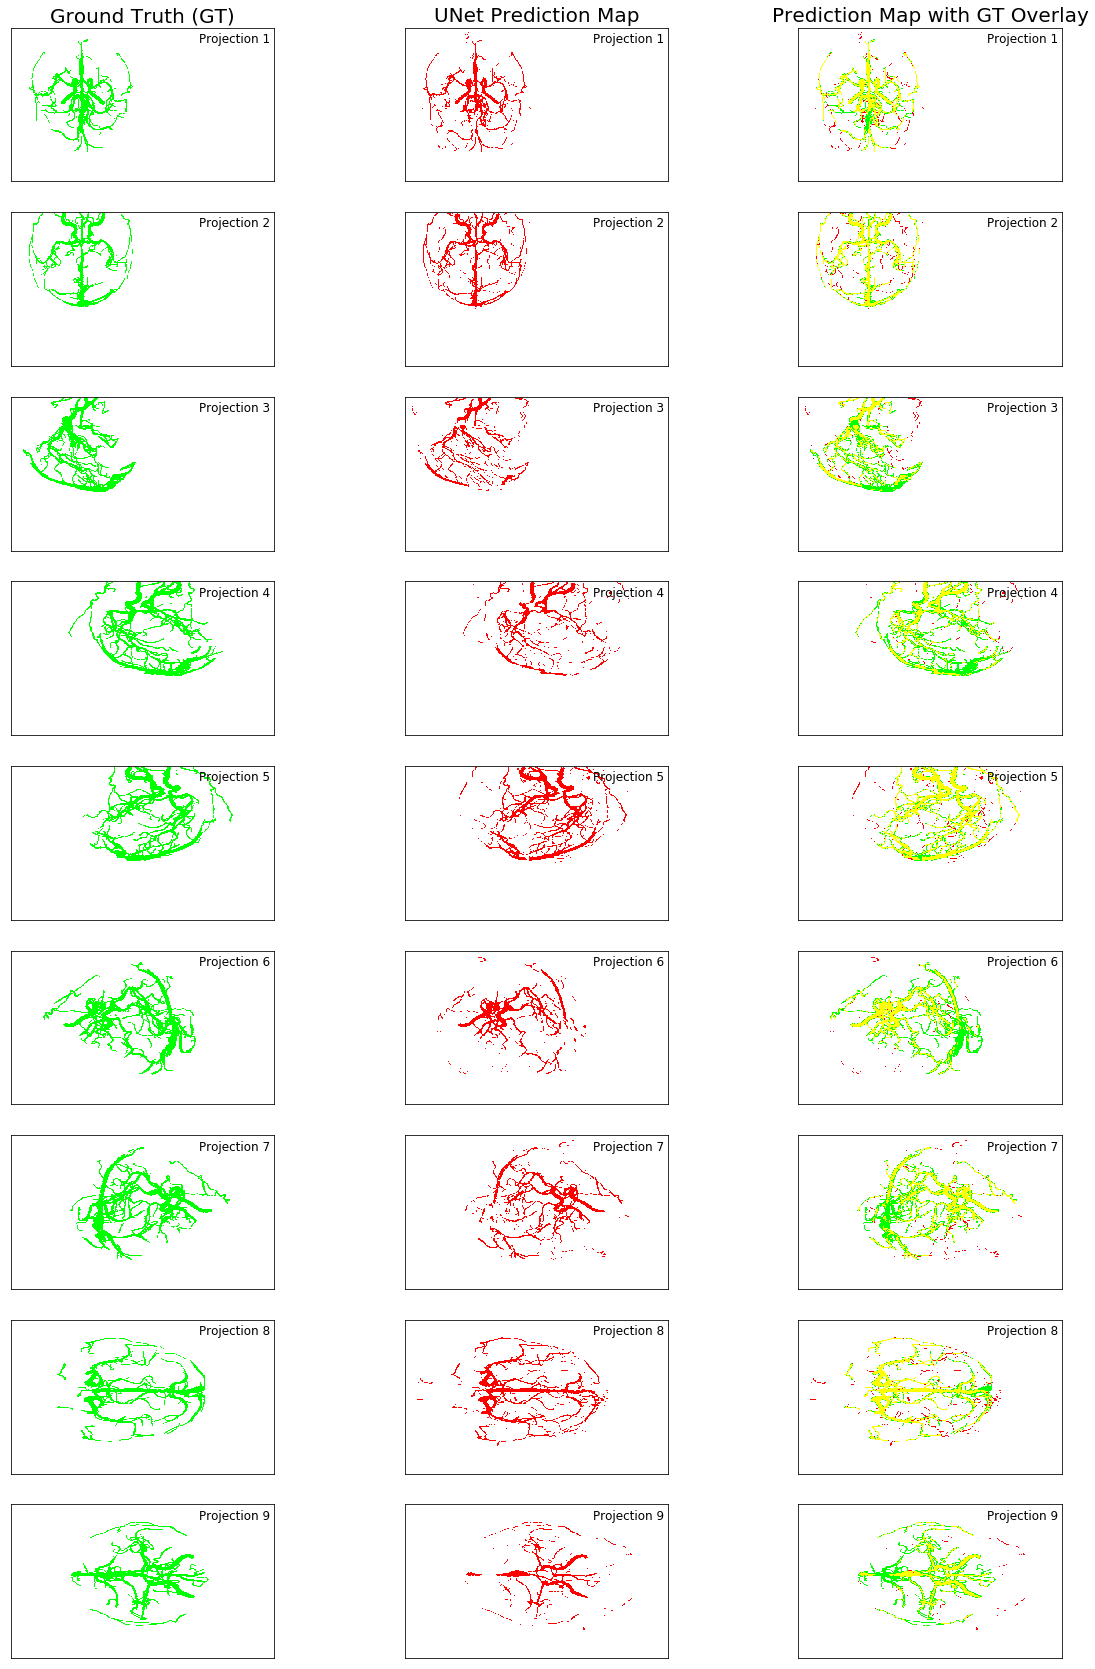

In [15]:
plot_all(j)

Test against a MRA record

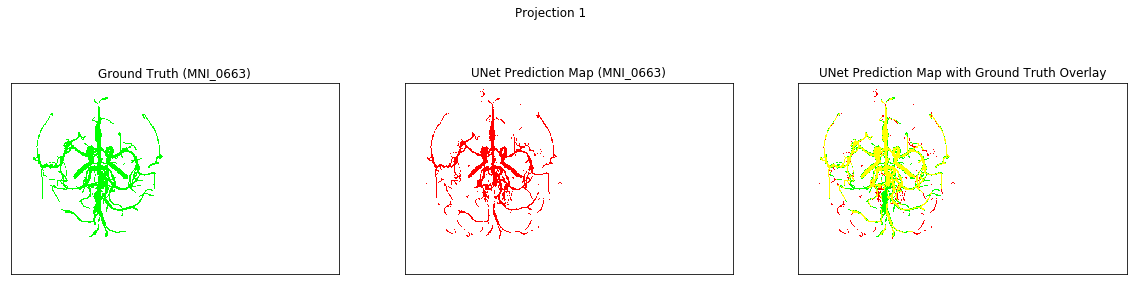

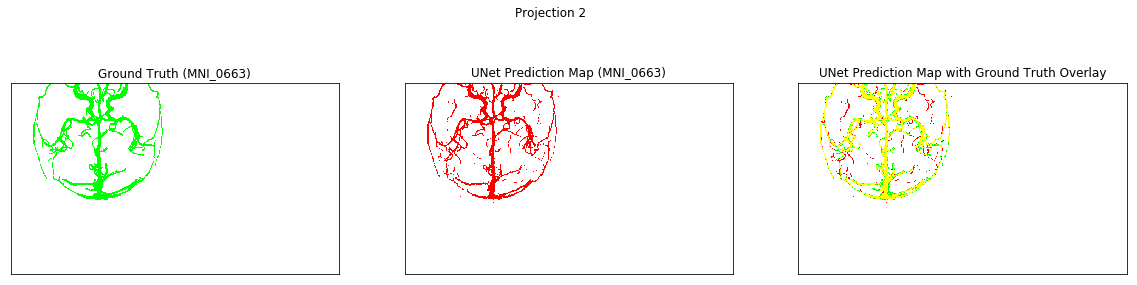

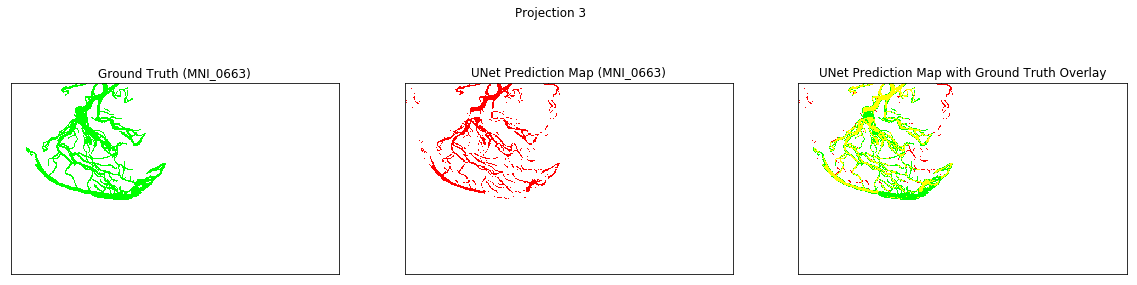

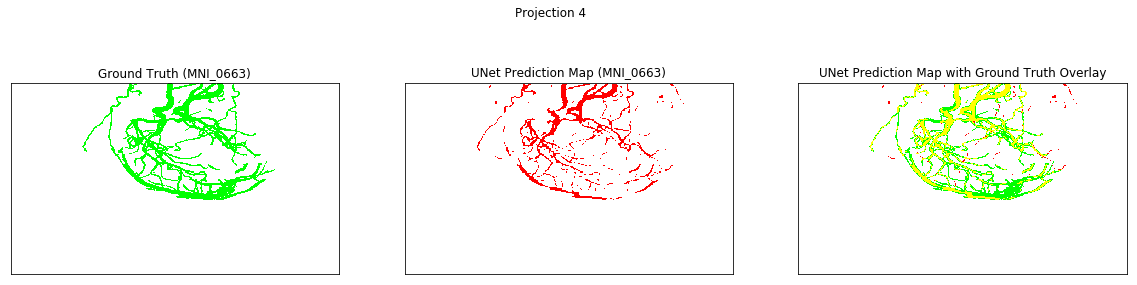

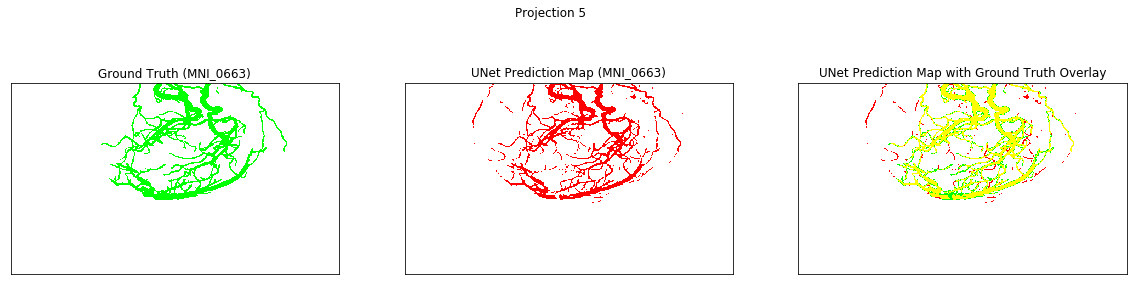

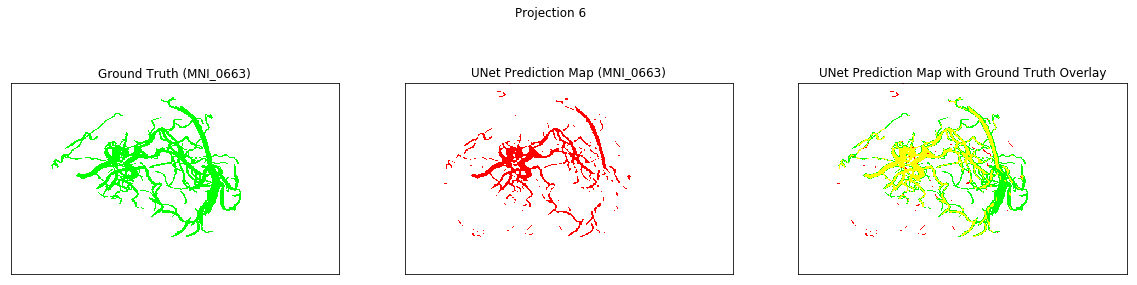

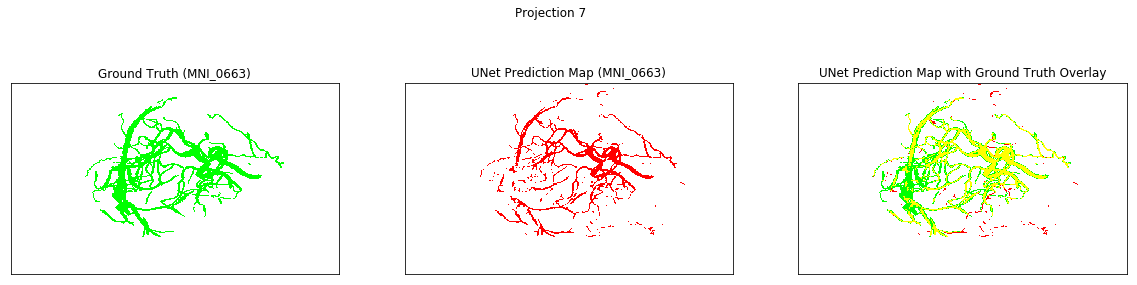

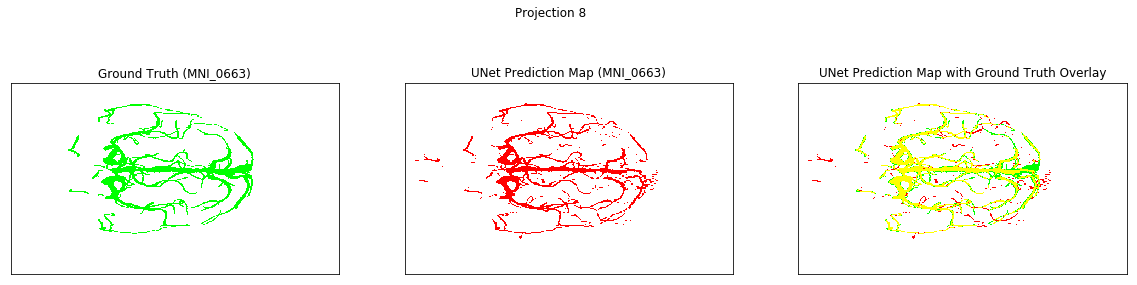

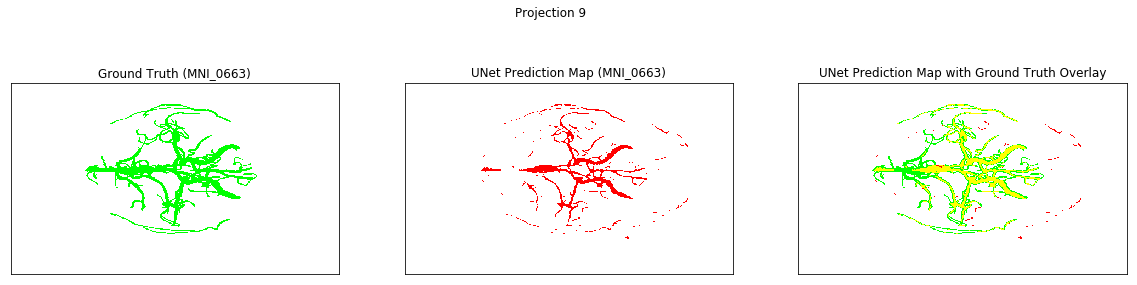

In [16]:
# Display GT / Prediction overlay maps

for i in range(app.NO_PROJECTIONS):
    plot_sample(mra_all[j],gt_trn[i,j,:350,:600],pred_trn[i,j,:350,:600], i)

Display Results by Projection

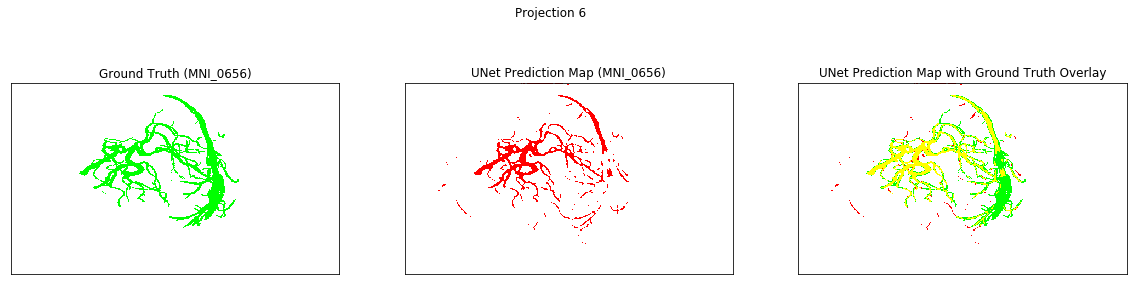

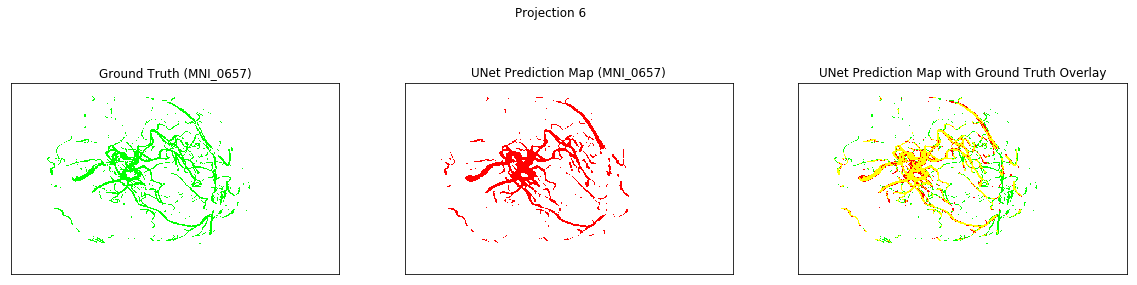

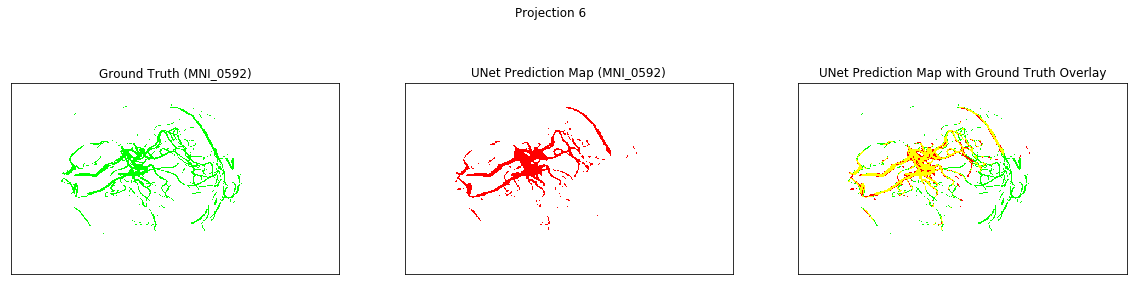

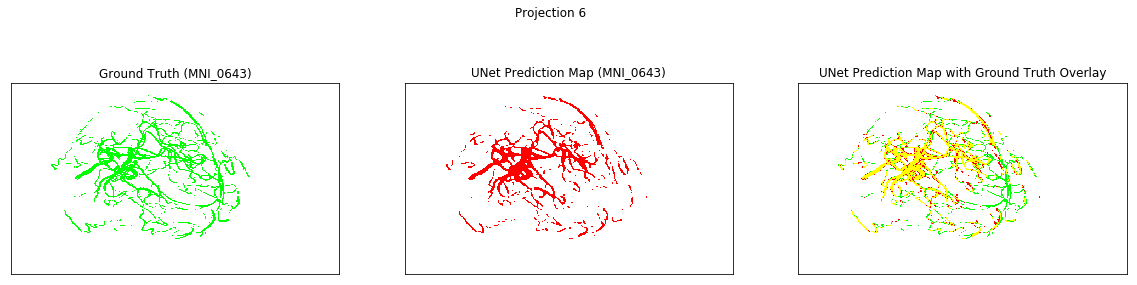

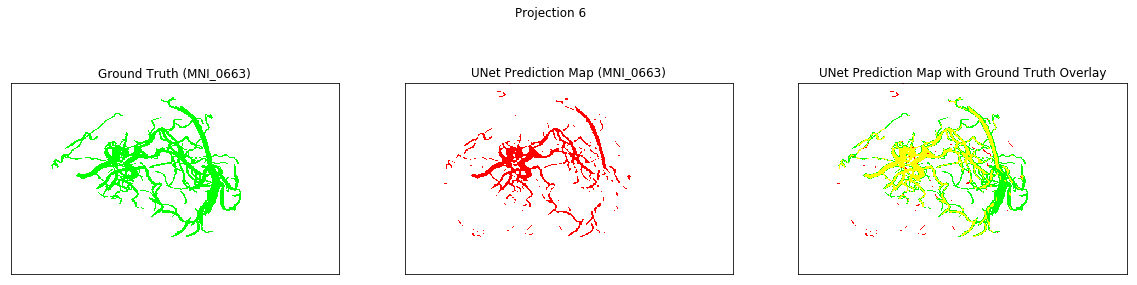

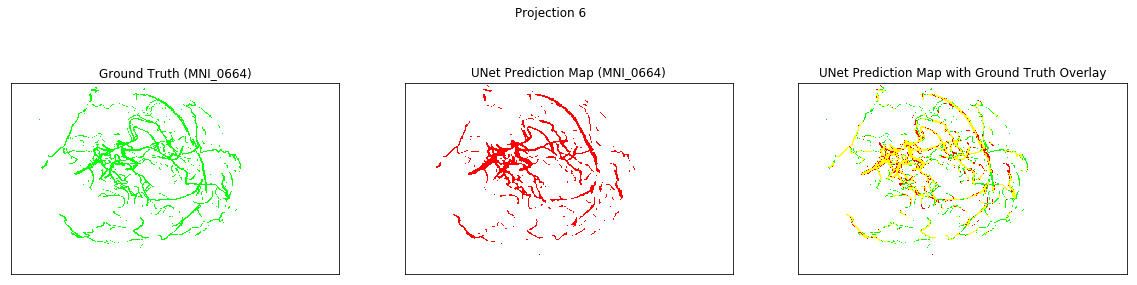

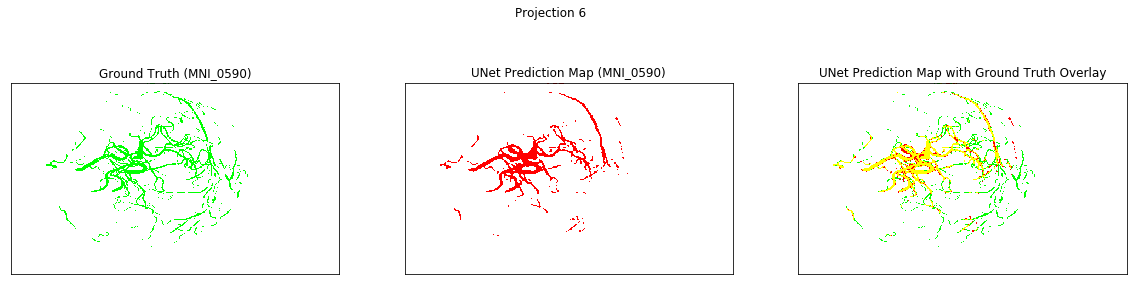

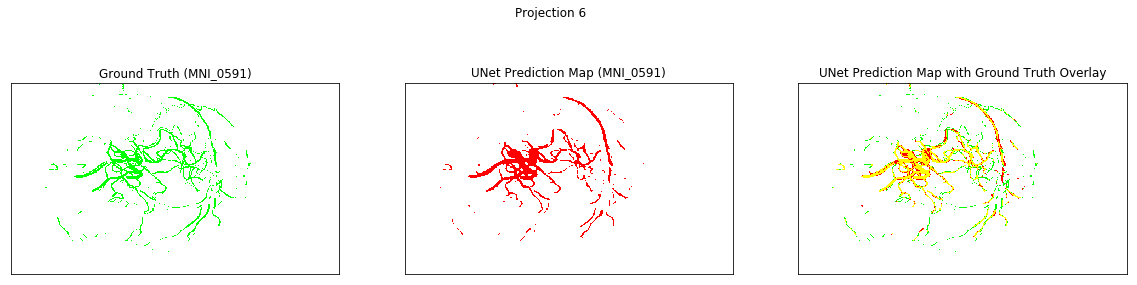

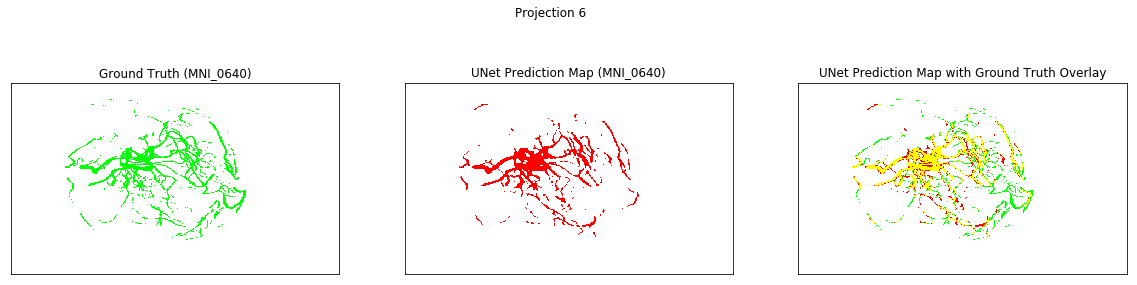

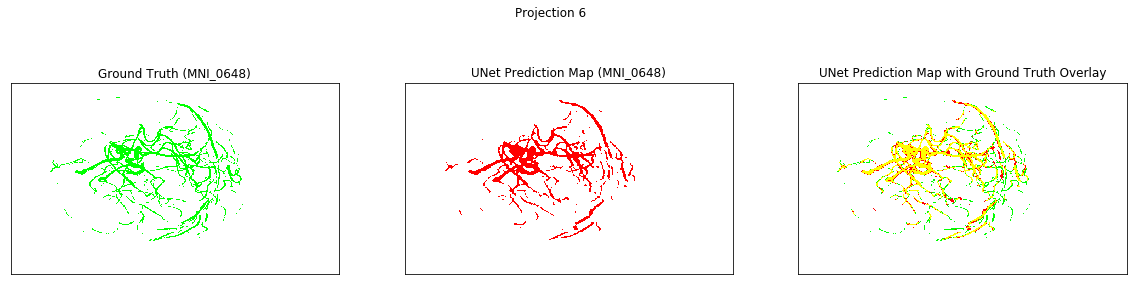

In [28]:
projection_idx = 5

for j in range(len(mra_all)):
    plot_sample(mra_all[j],gt_trn[projection_idx,j,:350,:600],pred_trn[projection_idx,j,:350,:600], projection_idx)

End of U-Net Evaluation